# Download SVHN and extract from label file

In [1]:
import imp
%matplotlib inline
import matplotlib.image as mpimg
svhn_images = imp.load_source('svhn_images', '../modules/svhn_images.py')

In [ ]:
import os

image_path='../data/SVHN/raw'
if not os.path.exists(image_path): 
    os.makedirs(image_path)

for data_kind in ['train', 'test']:
    print "Processing %s, please give this a few minutes to complete" % data_kind

    svhn_images.download_and_extract_SVHN(data_kind, image_path, '../data/SVHN/%s' % data_kind)

    print "Finished processing %s" % data_kind

# Data Exploration

Train data set:
Number of 1-digit sequences=5137
Number of 2-digit sequences=18130
Number of 3-digit sequences=8691
Number of 4-digit sequences=1434
Number of 5-digit sequences=9
Number of 6-digit sequences=1
Test data set:
Number of 1-digit sequences=2483
Number of 2-digit sequences=8356
Number of 3-digit sequences=2081
Number of 4-digit sequences=146
Number of 5-digit sequences=2


<Container object of 5 artists>

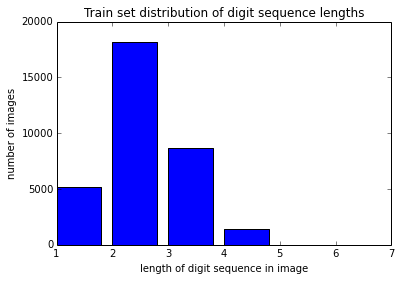

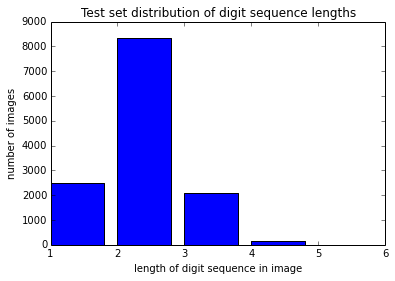

In [2]:
image_path='../data/SVHN/raw'

image_counts = svhn_images.count_images_by_length(image_path, data_kind='train')

train_numbers=[]
print "Train data set:"
for (k,v) in image_counts.items():
    print "Number of %d-digit sequences=%d" %(k, v)
    train_numbers.append(v)
    
image_counts = svhn_images.count_images_by_length(image_path, data_kind='test')

test_numbers=[]
print "Test data set:"
for k,v in image_counts.items():
    print "Number of %d-digit sequences=%d" %(k, v)
    test_numbers.append(v)
    
import matplotlib.pyplot as plt

plt.figure()
plt.title("Train set distribution of digit sequence lengths")
plt.xlabel("length of digit sequence in image")
plt.ylabel("number of images")
plt.bar( range(1, len(train_numbers)+ 1), train_numbers)

plt.figure()
plt.title("Test set distribution of digit sequence lengths")
plt.xlabel("length of digit sequence in image")
plt.ylabel("number of images")
plt.bar( range(1, len(test_numbers)+ 1), test_numbers)

test stats:
Average pct of area covered by digit in 1-digit images: 8.43
Average pct of area covered by digits in 2-digit images: 11.81
Average pct of area covered by digits in 3-digit images: 15.49
train stats:
Average pct of area covered by digit in 1-digit images: 13.47
Average pct of area covered by digits in 2-digit images: 21.78
Average pct of area covered by digits in 3-digit images: 22.04


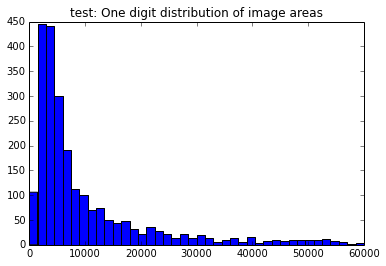

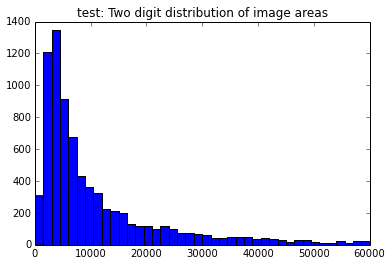

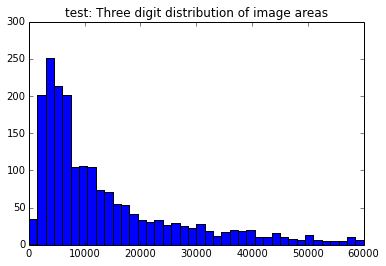

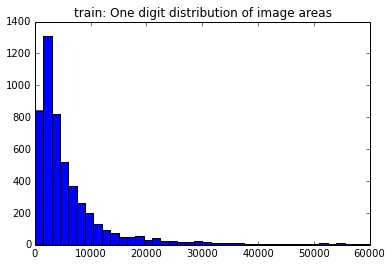

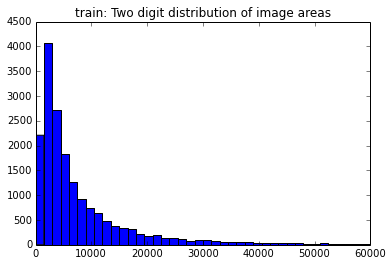

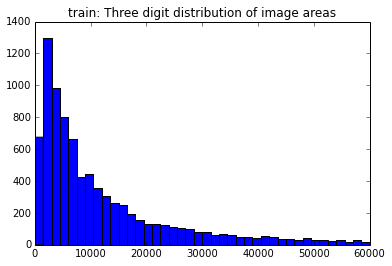

In [3]:

import numpy as np

def show_stats(test_type, images):
    digit_area_pct = np.zeros(3)
    digit_area_counts = np.zeros(3)
    digit_area_distribution = [[], [], []]

    for png in images:
        if png is not None:
            label = png.split('.')[0] + ".label"
            img = mpimg.imread("%s/images/%s/%s" % (image_path, test_type, png))
            box = svhn_images.get_outer_bounding_box("%s/images/%s/%s" % (image_path, test_type, png), "%s/labels/%s/%s" % (image_path, test_type, label))

            #determining if image is a 1-digit, 2-digit or 3-digit
            with open("%s/labels/%s/%s" % (image_path, test_type, label)) as f:
                for i, line in enumerate (f):
                    pass

            if i < 3 :
                digit_area_pct[i] += 100 * float(box.width * box.height) / (img.shape[0] * img.shape[1])
                digit_area_counts[i] += 1
                digit_area_distribution[i].append(img.shape[0] * img.shape[1])

    averages = (digit_area_pct / digit_area_counts)

    print "%s stats:" % test_type
    print "Average pct of area covered by digit in 1-digit images: %0.2f" % averages[0]
    print "Average pct of area covered by digits in 2-digit images: %0.2f" % averages[1]
    print "Average pct of area covered by digits in 3-digit images: %0.2f" % averages[2]


    plt.figure()
    plt.title("%s: One digit distribution of image areas" % test_type)
    plt.hist(digit_area_distribution[0], bins=40,range=(0,60000) )

    plt.figure()
    plt.title("%s: Two digit distribution of image areas" % test_type)
    plt.hist(digit_area_distribution[1], bins=40, range=(0,60000))

    plt.figure()
    plt.title("%s: Three digit distribution of image areas" % test_type)
    plt.hist(digit_area_distribution[2], bins=40, range=(0,60000))
    

show_stats ('test', svhn_images.get_list_of_filenames(image_path, data_kind='test', batch_size=13068, max_sequence_length=3))
show_stats ('train', svhn_images.get_list_of_filenames(image_path, data_kind='train', batch_size=33402, max_sequence_length=3))


(350, 741, 3)
(37, 74, 3)
(27, 67, 3)
(21, 44, 3)
(62, 137, 3)
(33, 66, 3)
(117, 295, 3)
(28, 68, 3)
(41, 95, 3)
(32, 74, 3)


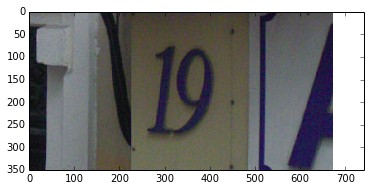

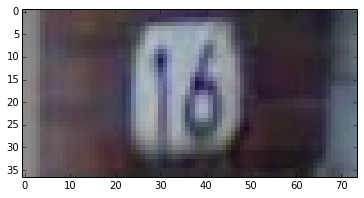

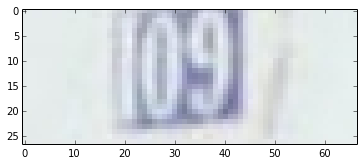

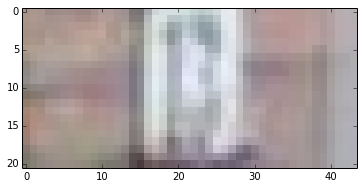

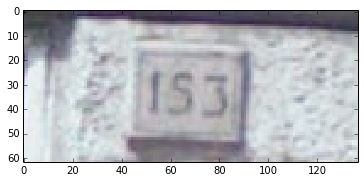

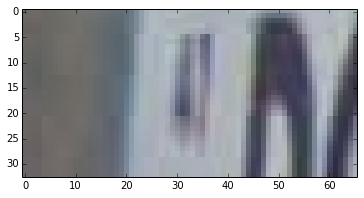

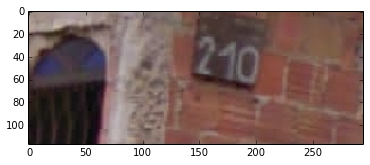

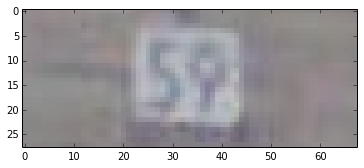

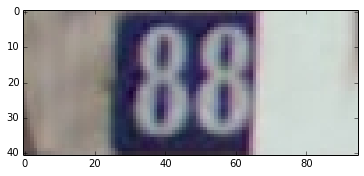

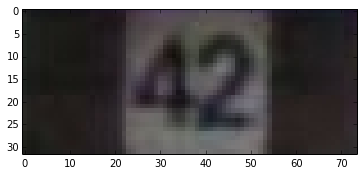

In [4]:
sample_of_images = svhn_images.get_list_of_filenames(image_path, data_kind='train', batch_size=10, max_sequence_length=3)


for f in [ "%s/images/%s/%s" % (image_path, 'train', png) for png in sample_of_images]:
    
    plt.figure()
    img = mpimg.imread(f)
    
    print img.shape
    plt.imshow(img, cmap='Greys', interpolation='nearest')

# Explore sample after image preprocessing

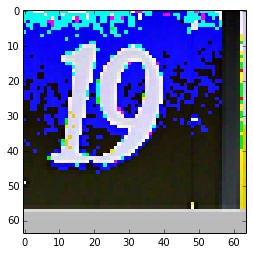

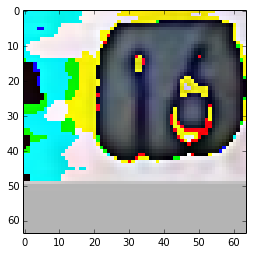

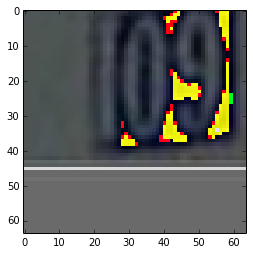

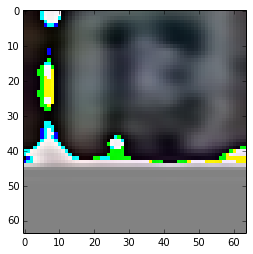

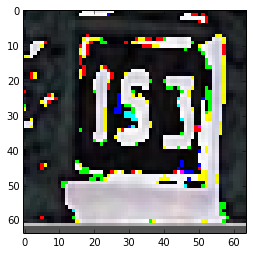

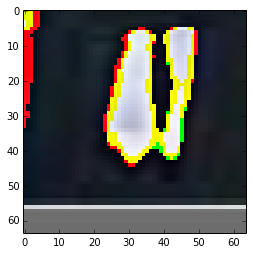

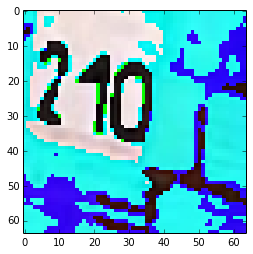

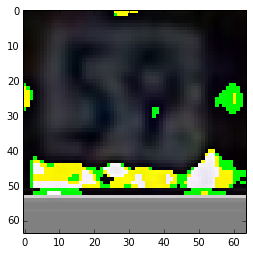

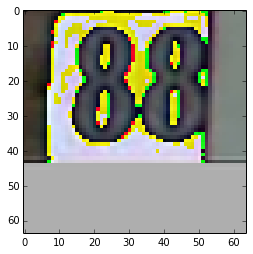

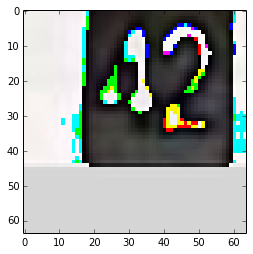

In [5]:
X, y1, y2, y3 = svhn_images.load_batch(sample_of_images, image_path, 'train', 10, 64, 3)

for i,_ in enumerate(sample_of_images):
    
    plt.figure()
    
    plt.imshow(X[i].reshape(64,64,3), cmap='Greys', interpolation='nearest')

# Load saved trained model

In [6]:
model = imp.load_source('model', '../modules/model.py')

m = model.Model()
tf_graph = m.getGraph()
session = m.init_interactive_session(tf_graph)

In [7]:
#Current model requires tensorflow v0.8

m.load_saved_model('../models/SVHN_model', session)

# Demostrate a few learning epochs

Note that the training phase was done over 48 hours, and here only a handful of ephocs are demonstrated

In [8]:
import random

keep_prob=0.5
image_path='../data/SVHN/raw'

# Total test set with 3 digits or less is 31958
NUMBER_OF_TRAIN_IMAGES = 31958
train_images_filenames = svhn_images.get_list_of_filenames(image_path, data_kind='train', batch_size=NUMBER_OF_TRAIN_IMAGES, max_sequence_length=3)

batch_size = 128

#running 10 epochs for demonstration only
for i in range(10):
    offset = random.randint(0, NUMBER_OF_TRAIN_IMAGES - batch_size)
    x, y1, y2, y3 = svhn_images.load_batch(train_images_filenames[offset:(offset+batch_size)],\
                                       image_path, 'train', 10, 64, 3)           

    m.run_training_epoch(session, x, y1, y2, y3, keep_prob=keep_prob)

# Test model against the test set

In [10]:
image_path='../data/SVHN/raw'

NUMBER_OF_TEST_IMAGES = 12920

test_images_filenames = svhn_images.get_list_of_filenames(image_path, data_kind='test', batch_size=NUMBER_OF_TEST_IMAGES, max_sequence_length=3)

batch_size = NUMBER_OF_TEST_IMAGES / 20

In [11]:
from sklearn.metrics import accuracy_score    
one_digit_image_acc = np.zeros(1)
two_digit_image_acc = np.zeros(2)
three_digit_image_acc = np.zeros(3)

i=0
j=0.0
digit1 = []
digit2 = []
digit3 = []

while  i < (NUMBER_OF_TEST_IMAGES - batch_size):

    batch_images = test_images_filenames[i:i+batch_size]

    X, y1, y2, y3 = svhn_images.load_batch(batch_images, image_path, 'test', 10, 64, 3)

    d1_logits, d2_logits, d3_logits = m.get_logits(session, X, y1, y2, y3)

    digit1_prediction, digit2_prediction, digit3_prediction = \
                np.argmax(d1_logits, 1), np.argmax(d2_logits, 1), np.argmax(d3_logits,1 )
    digit1_label, digit2_label, digit3_label = \
                np.argmax(y1, 1), np.argmax(y2, 1), np.argmax(y3, 1)

    three_digit_indexes = digit3_label != 10
    two_digit_indexes = (digit3_label == 10 ) & (digit2_label != 10 )
    one_digit_indexes = (digit3_label == 10 ) & (digit2_label == 10 )
    
    one_digit_image_acc[0] += accuracy_score(y_true=digit1_label[one_digit_indexes], y_pred=digit1_prediction[one_digit_indexes])
    two_digit_image_acc[0] += accuracy_score(y_true=digit1_label[two_digit_indexes], y_pred=digit1_prediction[two_digit_indexes])
    two_digit_image_acc[1] += accuracy_score(y_true=digit2_label[two_digit_indexes], y_pred=digit2_prediction[two_digit_indexes])

    three_digit_image_acc[0] += accuracy_score(y_true=digit1_label[three_digit_indexes], y_pred=digit1_prediction[three_digit_indexes])
    three_digit_image_acc[1] += accuracy_score(y_true=digit2_label[three_digit_indexes], y_pred=digit2_prediction[three_digit_indexes])
    three_digit_image_acc[2] += accuracy_score(y_true=digit3_label[three_digit_indexes], y_pred=digit3_prediction[three_digit_indexes])

    digit1.append(accuracy_score(y_true=digit1_label, y_pred=digit1_prediction))
    digit2.append(accuracy_score(y_true=digit2_label, y_pred=digit2_prediction))
    digit3.append(accuracy_score(y_true=digit3_label, y_pred=digit3_prediction))
    
    i=i+batch_size
    j=j+1


print "Avg 1-digit image accuracy of digit1=%0.2f" % (one_digit_image_acc[0] / (j))
print "Avg 2-digit image accuracy of digit1=%0.2f" % (two_digit_image_acc[0] / (j))
print "Avg 2-digit image accuracy of digit2=%0.2f" % (two_digit_image_acc[1] / (j))
print "Avg 3-digit image accuracy of digit1=%0.2f" % (three_digit_image_acc[0] / (j))
print "Avg 3-digit image accuracy of digit2=%0.2f" % (three_digit_image_acc[1] / (j))
print "Avg 3-digit image accuracy of digit3=%0.2f" % (three_digit_image_acc[2] / (j))

Avg 1-digit image accuracy of digit1=0.71
Avg 2-digit image accuracy of digit1=0.75
Avg 2-digit image accuracy of digit2=0.62
Avg 3-digit image accuracy of digit1=0.79
Avg 3-digit image accuracy of digit2=0.56
Avg 3-digit image accuracy of digit3=0.53


In [12]:
import numpy as np
print "Mean accuracy: digit_1 = %0.3f digit_2 = %0.3f digit_3 = %0.3f " % (np.array(digit1).mean(), np.array(digit2).mean(), np.array(digit3).mean())

Mean accuracy: digit_1 = 0.752 digit_2 = 0.669 digit_3 = 0.894 


In [13]:
print("Min digit 1 accuracy = %.1f" % (min(digit1) * 100 ))
print("Max digit 1 accuracy = %.1f" % (max(digit1) * 100 ))

print("Min digit 2 accuracy = %.1f" % (min(digit2) * 100 ))
print("Max digit 2 accuracy = %.1f" % (max(digit2) * 100 ))

print("Min digit 3 accuracy = %.1f" % (min(digit3) * 100 ))
print("Max digit 3 accuracy = %.1f" % (max(digit3) * 100 ))

Min digit 1 accuracy = 72.9
Max digit 1 accuracy = 77.1
Min digit 2 accuracy = 65.0
Max digit 2 accuracy = 69.8
Min digit 3 accuracy = 87.3
Max digit 3 accuracy = 92.3


{'boxes': [<matplotlib.lines.Line2D at 0x12fea8710>,
 'caps': [<matplotlib.lines.Line2D at 0x12fe88a50>,
 'fliers': [<matplotlib.lines.Line2D at 0x12febe3d0>,
 'medians': [<matplotlib.lines.Line2D at 0x12fea8d50>,
 'whiskers': [<matplotlib.lines.Line2D at 0x12fe88150>,
  <matplotlib.lines.Line2D at 0x10eef0850>]}

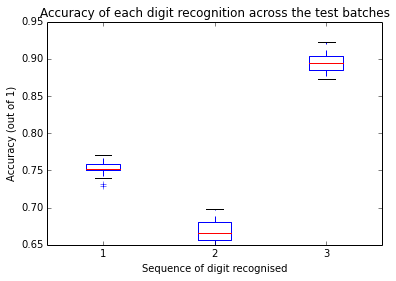

In [14]:
plt.title("Accuracy of each digit recognition across the test batches")
plt.xlabel("Sequence of digit recognised")
plt.ylabel("Accuracy (out of 1)")
plt.boxplot([digit1, digit2, digit3])